In [2]:
import numpy as np
import torch
import torch.nn as nn
import os
import onnxruntime as ort
import utils
from util_onnx import onnx_export
import utils
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "6,7"
import gc
gc.collect()

0

In [3]:
import os
import torch
import torch.nn as nn
from diffusers.schedulers import PNDMScheduler
from pathlib import Path
from diffusers import DiffusionPipeline
device = 'cpu'
dtype = torch.float32
save_path = '../onnx_models_cuda'
os.makedirs(save_path, exist_ok = True)

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32).to(device)

In [4]:
save_path = '../onnx_models_cuda'

In [5]:
def load_session(path, provider = 'cuda'):
    if provider == 'cuda':
        return ort.InferenceSession(path, providers=['AzureExecutionProvider'])
    else:
        return ort.InferenceSession(path)

In [6]:
sessTokenizer       = load_session(f'{save_path}/tokenizer/to_quant.onnx', 'cpu')
sessionTextEncoder  = load_session(f'{save_path}/text_encoder/te_quant.onnx', 'cpu')

sessUNetDown    = load_session(f'{save_path}/unet/udown_quant.onnx')
sessUNetMid     = load_session(f'{save_path}/unet/umid_quant.onnx')
sessUNetUp00    = load_session(f'{save_path}/unet/uup-0_quant.onnx')
sessUNetUp10    = load_session(f'{save_path}/unet/uup-1_quant.onnx')
sessUNetUp20    = load_session(f'{save_path}/unet/uup-2_quant.onnx')
sessUNetUp30    = load_session(f'{save_path}/unet/uup-3-0_quant.onnx')
sessUNetUp31    = load_session(f'{save_path}/unet/uup-3-1_quant.onnx')
sessUNetUp32    = load_session(f'{save_path}/unet/uup-3-2_quant.onnx')
sessUNetPost    = load_session(f'{save_path}/unet/upost_quant.onnx')

sessDecoder         = load_session(f'{save_path}/decoder/de_quant.onnx', 'cpu')

In [28]:
sessUNET = load_session('/root/workspace/ONNX-Models/projects/stabel_diffusion/onnx_model_by_diffusers/unet/model.onnx')

In [8]:
# Denoising-2) Scheduler
sessScheduler981     = load_session(f'{save_path}/scheduler_2/sche981_quant.onnx')
sessScheduler9611    = load_session(f'{save_path}/scheduler_2/sche9611_quant.onnx')
sessScheduler9612    = load_session(f'{save_path}/scheduler_2/sche9612_quant.onnx')
sessScheduler941     = load_session(f'{save_path}/scheduler_2/sche941_quant.onnx')
sessSchedulerNN      = load_session(f'{save_path}/scheduler_2/scheNN_quant.onnx')

onnx_root = '../onnx-models'
schedulers = {
    i:ort.InferenceSession(f'{onnx_root}/Schedulers_quant/{i}') for i in os.listdir(f'{onnx_root}/Schedulers_quant/')
}

In [9]:
sessUNetPre     = load_session(f'{save_path}/unet/upre_origin.onnx')
sessUNetPost_final     = load_session(f'{save_path}/unet/upost_final_quant.onnx')

[i.name for i in sessUNetPre.get_inputs()]
# sessUNetPre.run(None, {
#     'latents' : torch.randn([1,4,64,64]).detach().numpy(),
# })[0].shape
# pipeline.scheduler.scale_model_input(torch.randn([2,4,64,64]), 981).shape

['latents']

In [15]:
sessUpList  = [sessUNetUp00, sessUNetUp10, sessUNetUp20]
up_3_list   = [sessUNetUp30, sessUNetUp31, sessUNetUp32]

def forward_UNet(
    sample,             # x : [1 4 64 64]
    timestep,                       # t : [1]
    text_embed                      # text_embed : [2 77 768]
):
    #* Down
    outputs = sessUNetDown.run(None, {
        sessUNetDown.get_inputs()[0].name: sample,
        sessUNetDown.get_inputs()[1].name: timestep,
        sessUNetDown.get_inputs()[2].name: text_embed
    })
    sample, emb, down_block_res_samples = outputs[0], outputs[1], outputs[2:]
    #* Mid
    outputs = sessUNetMid.run(None, {
        sessUNetMid.get_inputs()[0].name: sample,
        sessUNetMid.get_inputs()[1].name: emb,
        sessUNetMid.get_inputs()[2].name: text_embed
    })
    sample = outputs[0]
    #* Up
    for i in range(3):
        res_samples = down_block_res_samples[-3 :]
        down_block_res_samples = down_block_res_samples[: -3]
        if i == 0:
            outputs = sessUpList[i].run(None, {
                sessUpList[i].get_inputs()[0].name: sample,
                sessUpList[i].get_inputs()[1].name: emb,
                sessUpList[i].get_inputs()[2].name: res_samples[0],
                sessUpList[i].get_inputs()[3].name: res_samples[1],
                sessUpList[i].get_inputs()[4].name: res_samples[2],
            })
            sample = outputs[0]
            # print(sample.shape)
        else:
            outputs = sessUpList[i].run(None, {
                sessUpList[i].get_inputs()[0].name: sample,
                sessUpList[i].get_inputs()[1].name: emb,
                sessUpList[i].get_inputs()[2].name: text_embed,
                sessUpList[i].get_inputs()[3].name: res_samples[0],
                sessUpList[i].get_inputs()[4].name: res_samples[1],
                sessUpList[i].get_inputs()[5].name: res_samples[2],
            })
            sample = outputs[0]          
    for i in range(3):
        outputs = up_3_list[i].run(None, {
            up_3_list[i].get_inputs()[0].name: sample,
            up_3_list[i].get_inputs()[1].name: emb,
            up_3_list[i].get_inputs()[2].name: text_embed,
            up_3_list[i].get_inputs()[3].name: down_block_res_samples[-(i+1)],
        })
        sample = outputs[0]
        
    outputs = sessUNetPost.run(None,{
            sessUNetPost.get_inputs()[0].name: sample,
    })
    sample = outputs[0]
    # print(sample.shape)
    return sample#, x

In [10]:
ascii_str   = utils.toAsciiTensor()
text_ids = sessTokenizer.run(None, {
    'input' : ascii_str.detach().cpu().numpy()
})[0]
embed = sessionTextEncoder.run(None, {
    'input' : text_ids
})[0]
print(text_ids.shape)
print(text_ids)
print(embed.shape)

(1, 77)
[[49407   320  3490  2368 49406     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]
(2, 77, 768)


In [11]:
latents0 = torch.tensor(np.load('./latenst_original.npy'))
#torch.randn([1,4,64,64], dtype= dtype, device =device)

In [37]:
pipeline.scheduler.set_timesteps(50, device=device)
timesteps = pipeline.scheduler.timesteps
timesteps
latents = latents0.clone()
extra_step_kwargs = {}
for i, t in enumerate(timesteps):
    # latents = latents.detach().numpy()
    # noise_pred = forward_UNet(
    #     x = latents,
    #     t = torch.tensor([t], dtype = torch.float32).detach().numpy(),
    #     text_embed = embed
    # )
    # predict the noise residual
    #* Pre
    latent_model_input = sessUNetPre.run(None, {
        sessUNetPre.get_inputs()[0].name: latents.detach().numpy(),
    })[0]
    noise_pred = sessUNET.run(None, {
        'sample'                : latent_model_input,
        'timestep'              : torch.tensor([t], dtype = torch.float32).detach().numpy(),
        'encoder_hidden_states' : embed
    })[0]
    # noise_pred = forward_UNet(
    #     sample      = latent_model_input,
    #     timestep    = torch.tensor([t], dtype = torch.float32).detach().numpy(),
    #     text_embed  = embed
    # )
    # noise_pred = pipeline.unet(
    #     torch.tensor(latent_model_input).to(device = device),
    #     t,
    #     encoder_hidden_states=torch.tensor(embed).to(device = device),
    #     cross_attention_kwargs=None,
    #     return_dict=False,
    # )[0]
    noise_pred = sessUNetPost_final.run(None,{
        sessUNetPost_final.get_inputs()[0].name: noise_pred#.detach().numpy(),
    })[0]
    noise_pred = torch.tensor(noise_pred)
    
    if t == 981:
        pipeline.scheduler.ets = [noise_pred]           # self.ets.append(model_output)
        pipeline.scheduler.cur_sample = latents
        
        noise_pred  = noise_pred.detach().numpy()
        latents     = latents.detach().numpy()
        latents     = sessScheduler981.run(None, {
            'model_output' : noise_pred,
            'sample'       : latents,  
        })[0]
        pipeline.scheduler.counter = 1
        latents     = torch.tensor(latents)
    elif t == 961 and i == 1:
        latents = sessScheduler9611.run(None, {
            'model_output'  : noise_pred.detach().numpy(),
            'cur_sample'    : pipeline.scheduler.cur_sample.detach().numpy(),
            'ets0'          : pipeline.scheduler.ets[-1].detach().numpy()
        })[0]
        pipeline.scheduler.counter = 2
        pipeline.scheduler.cur_sample = None
        latents     = torch.tensor(latents)
    elif t == 961 and i == 2: 
        latents = sessScheduler9612.run(None, {
            'model_output'  : noise_pred.detach().numpy(),
            'sample'        : latents.detach().numpy(),
            'ets0'          : pipeline.scheduler.ets[-1].detach().numpy()
        })[0]
        pipeline.scheduler.counter = 3
        pipeline.scheduler.ets.append(noise_pred)           # self.ets.append(model_output)
        latents     = torch.tensor(latents)
    elif t == 941:
        latents = sessScheduler941.run(None, {
            'model_output'  : noise_pred.detach().numpy(),
            'sample'        : latents.detach().numpy(),
            'ets0'          : pipeline.scheduler.ets[-1].detach().numpy(),
            'ets1'          : pipeline.scheduler.ets[-2].detach().numpy()
        })[0]
        pipeline.scheduler.counter = 4
        pipeline.scheduler.ets.append(noise_pred)           # self.ets.append(model_output)
        latents     = torch.tensor(latents)
    else:
        latents = schedulers[f'step-{t}.onnx'].run(None, {
            'noise_pred'    : noise_pred.detach().numpy(),
            'latents'       : latents.detach().numpy(),
            'ets1'          : pipeline.scheduler.ets[-1].detach().numpy(),        
            'ets2'          : pipeline.scheduler.ets[-2].detach().numpy(),
            'ets3'          : pipeline.scheduler.ets[-3].detach().numpy()
        })[0]
        pipeline.scheduler.counter = i + 1
        pipeline.scheduler.ets = pipeline.scheduler.ets[-3:]
        pipeline.scheduler.ets.append(noise_pred)
        latents     = torch.tensor(latents)
    # latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
    print(t, end=' -> ' if (i%10 != 0 and i!= 0) else ' -> \n')

In [32]:
[i.name for i in sessUNET.get_inputs()]

['sample', 'timestep', 'encoder_hidden_states']

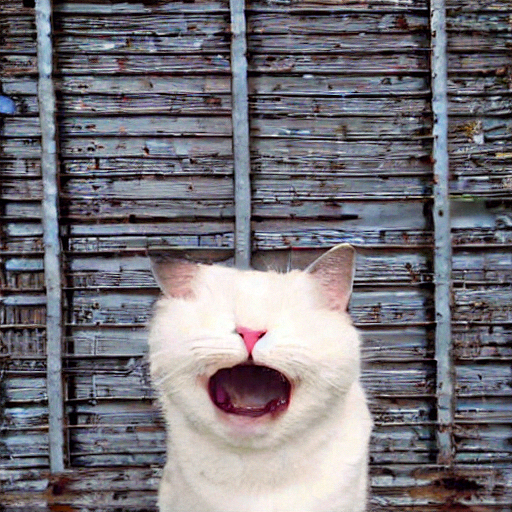

In [20]:
from PIL import Image
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

image = sessDecoder.run(None, {
    'input' : latents.detach().numpy()
})[0]
image = numpy_to_pil(image)
image[0].show()